In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import os
import trimesh
import b3d
from jax.scipy.spatial.transform import Rotation as Rot
from b3d import Pose
#from b3d.utils import unproject_depth
import rerun as rr
import genjax
from tqdm import tqdm


rr.init("demo.py")
rr.connect("127.0.0.1:8812")
#rr.save('single_box_view_uncorrected.rrd')


In [2]:
width=128
height=128
fx=64.0
fy=64.0
cx=64.0
cy=64.0
near=0.001
far=16.0
renderer = b3d.Renderer(
    width, height, fx, fy, cx, cy, near, far
)

In [3]:
def rotation_from_axis_angle(axis, angle):
    """Creates a rotation matrix from an axis and angle.

    Args:
        axis (jnp.ndarray): The axis vector. Shape (3,)
        angle (float): The angle in radians.
    Returns:
        jnp.ndarray: The rotation matrix. Shape (3, 3)
    """
    sina = jnp.sin(angle)
    cosa = jnp.cos(angle)
    direction = axis / jnp.linalg.norm(axis)
    # rotation matrix around unit vector
    R = jnp.diag(jnp.array([cosa, cosa, cosa]))
    R = R + jnp.outer(direction, direction) * (1.0 - cosa)
    direction = direction * sina
    R = R + jnp.array(
        [
            [0.0, -direction[2], direction[1]],
            [direction[2], 0.0, -direction[0]],
            [-direction[1], direction[0], 0.0],
        ]
    )
    return R

def transform_from_rot(rotation):
    """Creates a pose matrix from a rotation matrix.

    Args:
        rotation (jnp.ndarray): The rotation matrix. Shape (3, 3)
    Returns:
        jnp.ndarray: The pose matrix. Shape (4, 4)
    """
    return jnp.vstack(
        [jnp.hstack([rotation, jnp.zeros((3, 1))]), jnp.array([0.0, 0.0, 0.0, 1.0])]
    )

def transform_from_axis_angle(axis, angle):
    """Creates a pose matrix from an axis and angle.

    Args:
        axis (jnp.ndarray): The axis vector. Shape (3,)
        angle (float): The angle in radians.
    Returns:
        jnp.ndarray: The pose matrix. Shape (4, 4)
    """
    return transform_from_rot(rotation_from_axis_angle(axis, angle))



In [4]:
r_mat = transform_from_axis_angle(jnp.array([0,0,1]), jnp.pi/2)

In [5]:

vec_transform_axis_angle = jax.vmap(transform_from_axis_angle, (None, 0))
rots = vec_transform_axis_angle(jnp.array([0,0,1]), jnp.linspace(jnp.pi/8, 4*jnp.pi/8, 30)) 

In [6]:
mesh_path = os.path.join(b3d.get_root_path(),
    "assets/shared_data_bucket/ycb_video_models/models/003_cracker_box/textured_simple.obj")
mesh = trimesh.load(mesh_path)

object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)

cam_inv_pose = b3d.Pose.from_position_and_target(
    jnp.array([0.15, 0.15, 0.0]),
    jnp.array([0.0, 0.0, 0.0])
).inv()


in_place_rots = b3d.Pose.from_matrix(rots)


compound_pose = cam_inv_pose @ in_place_rots #in_place_rot



rgbs, depths = renderer.render_attribute_many(
    compound_pose[:,None,...],
    object_library.vertices,
    object_library.faces,
    jnp.array([[0, len(object_library.faces)]]),
    object_library.attributes
)
#b3d.get_rgb_pil_image(rgb).save(b3d.get_root_path() / "assets/test_ycb.png")

In [7]:
class Intrinsics:
    width=128
    height=128
    fx=64.0
    fy=64.0
    cx=64.0
    cy=64.0
    near=0.001
    far=16.0

intrinsics = Intrinsics()

def unproject_depth(depth, intrinsics):
    """Unprojects a depth image into a point cloud.

    Args:
        depth (jnp.ndarray): The depth image. Shape (H, W)
        intrinsics (b.camera.Intrinsics): The camera intrinsics.
    Returns:
        jnp.ndarray: The point cloud. Shape (H, W, 3)
    """
    mask = (depth < intrinsics.far) * (depth > intrinsics.near)
    depth = depth * mask + intrinsics.far * (1.0 - mask)
    y, x = jnp.mgrid[: depth.shape[0], : depth.shape[1]]
    x = (x - intrinsics.cx) / intrinsics.fx
    y = (y - intrinsics.cy) / intrinsics.fy
    point_cloud_image = jnp.stack([x, y, jnp.ones_like(x)], axis=-1) * depth[:, :, None]
    return point_cloud_image

In [8]:
unproject_depth_vec = jax.vmap(unproject_depth, (0, None))

In [9]:
xyzs = unproject_depth_vec(depths, intrinsics)

In [10]:
from b3d import Pose

num_layers = 2048
renderer = b3d.Renderer(width, height, fx, fy, cx, cy, near, far, num_layers)
model = b3d.model_multiobject_gl_factory(renderer)
importance_jit = jax.jit(model.importance)
update_jit = jax.jit(model.update)

# Arguments of the generative model.
# These control the inlier / outlier decision boundary for color error and depth error.
#color_error, depth_error = (jnp.float32(30.0), jnp.float32(0.02))
color_error, depth_error = (jnp.float32(30.0), jnp.float32(0.01))
# TODO: explain
inlier_score, outlier_prob = (jnp.float32(50.0), jnp.float32(0.001)) # 5
# TODO: explain
color_multiplier, depth_multiplier = (jnp.float32(3000.0), jnp.float32(3000.0))


# Defines the enumeration schedule.
key = jax.random.PRNGKey(0)
# Gridding on translation only.

delta = 0.005
translation_deltas = Pose.concatenate_poses([jax.vmap(lambda p: Pose.from_translation(p))(jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-delta, delta, 11),
        jnp.linspace(-delta, delta, 11),
        jnp.linspace(-delta, delta, 11),
    ),
    axis=-1,
).reshape(-1, 3)), Pose.identity()[None,...]])
# Sample orientations from a VMF to define a "grid" over orientations.
rotation_deltas = Pose.concatenate_poses([jax.vmap(Pose.sample_gaussian_vmf_pose, in_axes=(0,None, None, None))(
    jax.random.split(jax.random.PRNGKey(0), 11*11*11),
    Pose.identity(),
    0.00001, 10.0
), Pose.identity()[None,...]])
all_deltas =  Pose.stack_poses([translation_deltas, rotation_deltas])
all_deltas = (all_deltas[0] @ all_deltas[1])[None,...]

In [11]:
# Make empty library
object_library = b3d.MeshLibrary.make_empty_library()

In [12]:
x_center = 64
y_center = 64 
del_pix = 5 

local_points = xyzs[0,x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:].reshape(-1,3)
local_rgbs = rgbs[0,x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:].reshape(-1,3)
patch_center = xyzs[0,x_center,y_center,:]

point_cloud = local_points
point_cloud_colors = local_rgbs

In [13]:
def _enumerate_and_return_scores(trace, addressses, key, all_deltas):
    addr = addressses.const[0]
    current_pose = trace[addr]
    for i in range(len(all_deltas)):
        test_poses = current_pose @ all_deltas[i]
        potential_scores = b3d.enumerate_choices_get_scores(
            trace, jax.random.PRNGKey(0), addressses, test_poses
        )
        #current_pose = test_poses[potential_scores.argmax()]
    #trace = b3d.update_choices(trace, key, addressses, current_pose)
    return test_poses, potential_scores


enumerate_and_return_scores = jax.jit(
    _enumerate_and_return_scores, static_argnames=["addressses"]
)

In [14]:
# Create new mesh.
vertices, faces, vertex_colors, face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
    point_cloud, point_cloud_colors, point_cloud[:,2] / fx * 2.0
)
object_pose = Pose.from_translation(vertices.mean(0))
vertices = object_pose.inverse().apply(vertices)
object_library.add_object(vertices, faces, vertex_colors)


In [15]:

model_args = b3d.model.ModelArgs(color_error, depth_error,
                            inlier_score, outlier_prob,
                            color_multiplier, depth_multiplier)

trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        dict([
            ("camera_pose", Pose.identity()),
            ("object_pose_0", object_pose),
            ("object_0", 0),
            ("observed_rgb_depth", (rgbs[0], xyzs[0,...,2])),
        ])
    ),
    (jnp.arange(1),model_args, object_library)
)

# Visualize trace
#b3d.rerun_visualize_trace_t(trace, 0)

FINAL_T = len(xyzs)
scores = []
for T_observed_image in tqdm(range(0, FINAL_T)):
    # Constrain on new RGB and Depth data.
    trace = b3d.update_choices_jit(trace, key,
        genjax.Pytree.const(["observed_rgb_depth"]),
        (rgbs[T_observed_image],xyzs[T_observed_image,...,2])
    )
    trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const(["camera_pose"]), key, all_deltas)
    # trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const([f"object_pose_0"]), key, all_deltas)

    poses, grid_scores = enumerate_and_return_scores(trace, genjax.Pytree.const(["object_pose_0"]), key, all_deltas)
    indices = jnp.argsort(-grid_scores)
    (observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = trace.get_retval()

    image_sum = np.zeros(rendered_rgb.shape)

    # this is wrong, just a visualization of the fineness of the grid

    for ind in indices[:50:5]:
        temp_trace = b3d.update_choices_jit(trace, key, genjax.Pytree.const([f"object_pose_0"]), poses[ind])
        (observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = temp_trace.get_retval()
        image_sum += np.array(rendered_rgb)

    image_sum /= 10
    
    trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const([f"object_pose_0"]), key, all_deltas)

    (observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = trace.get_retval()

    score = trace.get_score()
    scores.append(score)
    #b3d.rerun_visualize_trace_t(trace, T_observed_image)

    rr.set_time_sequence("frame", T_observed_image)
    rr.log("/vmf_tracking", rr.Image(observed_rgb))
    rr.log("/vmf_tracking/rgb_rendering", rr.Image(rendered_rgb))
    rr.log("/rendered_vmf_patches/alpha_blend_patch", rr.Image(image_sum))
    rr.log('/vmf_score', rr.TimeSeriesScalar(score))

    (inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask) = b3d.get_rgb_depth_inliers_from_trace(trace)
    rr.log("/vmf_tracking/color_inliers", rr.DepthImage(color_inliers * 1.0))

  0%|          | 0/30 [00:00<?, ?it/s]/var/tmp/ipykernel_26579/4099740163.py:57: DeprecationWarning: Use the `Scalar` + (optional) `SeriesLine`/`SeriesPoint` archetypes instead, logged on the same entity. See [0.13 migration guide](https://www.rerun.io/docs/reference/migration/migration-0-13).
  rr.log('/vmf_score', rr.TimeSeriesScalar(score))
100%|██████████| 30/30 [00:17<00:00,  1.70it/s]


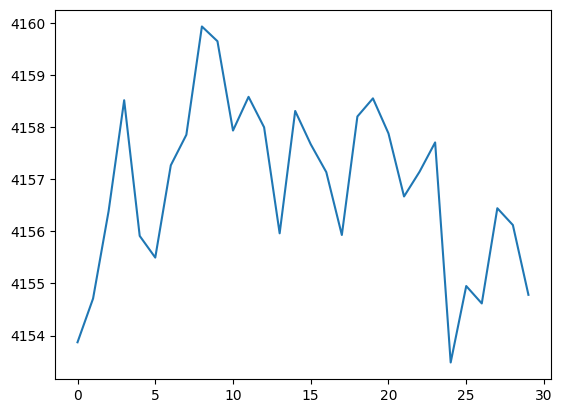

In [16]:
plt.plot(scores)

In [17]:
vertices, faces, vertex_colors, face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
    point_cloud, point_cloud_colors, point_cloud[:,2] / fx * 2.0
)
object_pose = Pose.identity()
vertices = object_pose.inverse().apply(vertices)
object_library.add_object(vertices, faces, vertex_colors)


In [ ]:
## code to generate ground-truth trajectory and score under model - need to resolve the bug of why inference is doing better in this model than the original model

In [18]:
model_args = b3d.model.ModelArgs(color_error, depth_error,
                            inlier_score, outlier_prob,
                            color_multiplier, depth_multiplier)

trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        dict([
            ("camera_pose", Pose.identity()),
            ("object_pose_0", Pose.identity()),
            ("object_0", 1),
            ("observed_rgb_depth", (rgbs[0], xyzs[0,...,2])),
        ])
    ),
    (jnp.arange(2),model_args, object_library)
)

# Visualize trace
#b3d.rerun_visualize_trace_t(trace, 0)


FINAL_T = len(xyzs)
scores = []
for T_observed_image in tqdm(range(FINAL_T)):
    # Constrain on new RGB and Depth data.
    trace = b3d.update_choices_jit(trace, key,
        genjax.Pytree.const(["observed_rgb_depth"]),
        (rgbs[T_observed_image],xyzs[T_observed_image,...,2])
    )
    #trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const(["camera_pose"]), key, all_deltas)
    #trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const([f"object_pose_0"]), key, all_deltas)

    #in_place_rots[T_observed_image] @ in_place_rots[T_observed_image-1].inv() @ 

    update_pose = cam_inv_pose @ in_place_rots[T_observed_image] @ in_place_rots[0].inv() @ cam_inv_pose.inv()

    trace = b3d.update_choices_jit(trace, key, genjax.Pytree.const([f"object_pose_0"]), update_pose)

    score = trace.get_score()
    scores.append(score)
    #b3d.rerun_visualize_trace_t(trace, T_observed_image)
    
    (observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = trace.get_retval()
    rr.set_time_sequence("frame", T_observed_image)
    rr.log("/gt_tracking", rr.Image(observed_rgb))
    rr.log("/gt_tracking/rgb_rendering", rr.Image(rendered_rgb))
    rr.log('/gt_score', rr.TimeSeriesScalar(score))

    (inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask) = b3d.get_rgb_depth_inliers_from_trace(trace)
    rr.log("/gt_tracking/color_inliers", rr.DepthImage(color_inliers * 1.0))

  0%|          | 0/30 [00:00<?, ?it/s]/var/tmp/ipykernel_26579/3717927701.py:47: DeprecationWarning: Use the `Scalar` + (optional) `SeriesLine`/`SeriesPoint` archetypes instead, logged on the same entity. See [0.13 migration guide](https://www.rerun.io/docs/reference/migration/migration-0-13).
  rr.log('/gt_score', rr.TimeSeriesScalar(score))
100%|██████████| 30/30 [00:07<00:00,  4.12it/s]


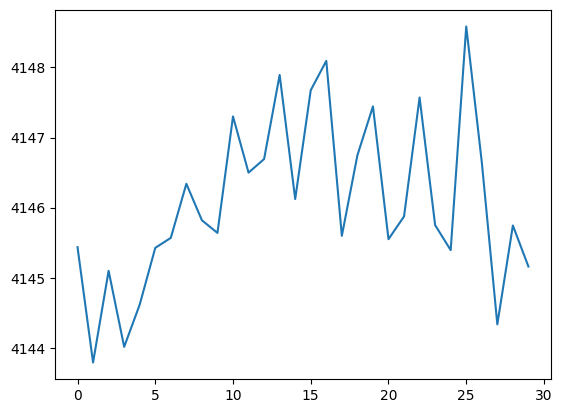

In [19]:
plt.plot(scores)

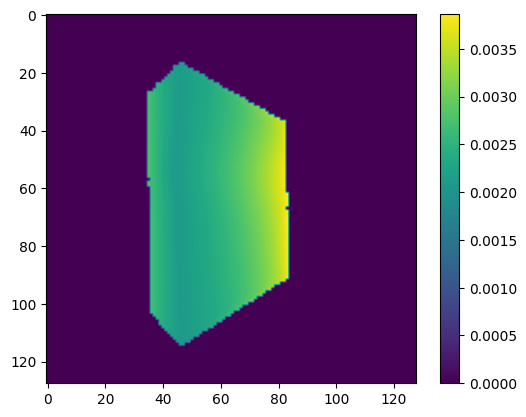

In [20]:
plt.imshow(np.multiply(observed_depth/fx, observed_depth/fx<0.15))
plt.colorbar()

In [21]:
# points = rr.Points3D(unproject_depth(observed_depth, intrinsics).reshape(-1,3), colors=observed_rgb.reshape(-1,3))
# rr.log("cloud1", points)

# points2 = rr.Points3D((trace[f"object_pose_0"]).apply(object_library.vertices), colors=object_library.attributes)
# rr.log("cloud2", points2)

In [22]:
# repeated tracker

In [23]:
# samples from the posterior: importance sampling

In [24]:
# grid translations, rotations
all_deltas.position.shape

(1, 1332, 3)

In [25]:
collapsed_deltas = all_deltas[0] @ all_deltas[1]

In [26]:
poses, scores = enumerate_and_return_scores(trace, genjax.Pytree.const([f"object_pose_0"]), key, all_deltas[0][None,...])

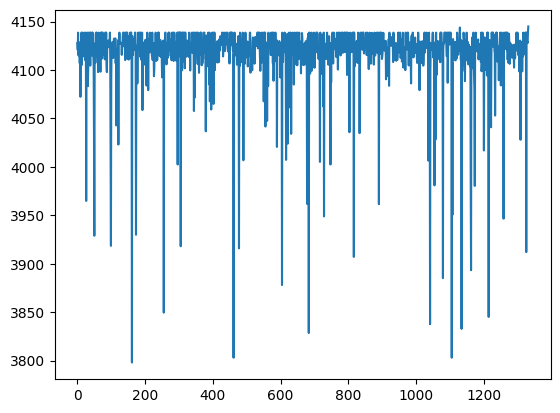

In [27]:
plt.plot(scores)

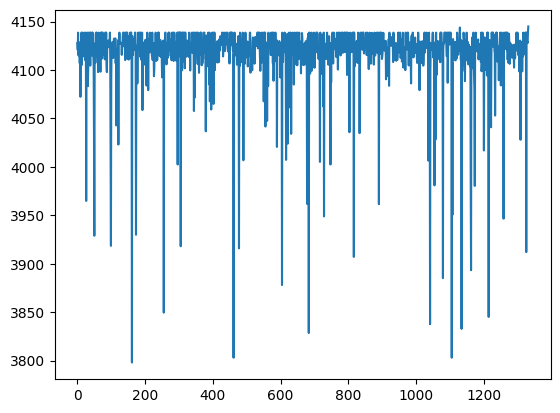

In [28]:
poses, scores = enumerate_and_return_scores(trace, genjax.Pytree.const([f"object_pose_0"]), key, all_deltas[1][None,...])
plt.plot(scores)

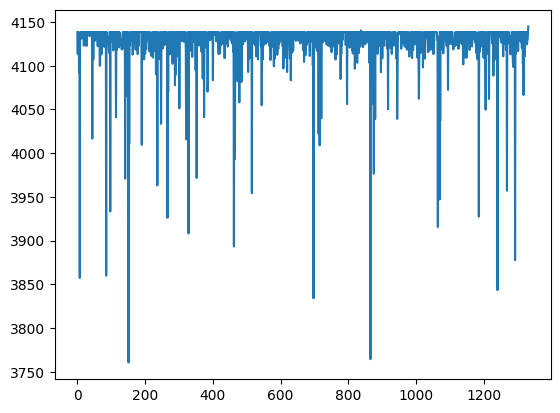

In [29]:
poses, scores = enumerate_and_return_scores(trace, genjax.Pytree.const([f"object_pose_0"]), key, collapsed_deltas[None,...])
plt.plot(scores)

In [30]:
scores -= jnp.max(scores)

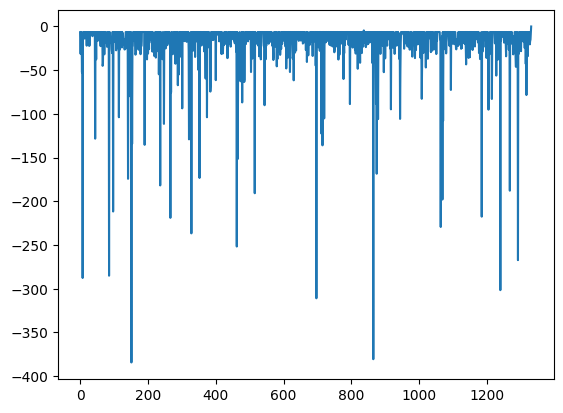

In [31]:
plt.plot(scores)

In [32]:
indices = jnp.argsort(scores)

In [33]:
rr.init("demo.py")
rr.connect("127.0.0.1:8812")

In [34]:
trace = b3d.update_choices_jit(trace, key, genjax.Pytree.const([f"object_pose_0"]), poses[indices[-3]])

score = trace.get_score()
#b3d.rerun_visualize_trace_t(trace, T_observed_image)

(observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = trace.get_retval()
rr.set_time_sequence("frame", T_observed_image)
rr.log("/gt_tracking", rr.Image(observed_rgb))
rr.log("/gt_tracking/rgb_rendering", rr.Image(rendered_rgb))
rr.log('/gt_score', rr.TimeSeriesScalar(score))

(inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask) = b3d.get_rgb_depth_inliers_from_trace(trace)
rr.log("/gt_tracking/color_inliers", rr.DepthImage(color_inliers * 1.0))

/var/tmp/ipykernel_26579/3112553192.py:10: DeprecationWarning: Use the `Scalar` + (optional) `SeriesLine`/`SeriesPoint` archetypes instead, logged on the same entity. See [0.13 migration guide](https://www.rerun.io/docs/reference/migration/migration-0-13).
  rr.log('/gt_score', rr.TimeSeriesScalar(score))


In [35]:
scores[indices[-1]]

Array(0., dtype=float32)

In [36]:
scores[indices[-2]]

Array(-4.517578, dtype=float32)

In [37]:
scores[indices[-3]]

Array(-6.286621, dtype=float32)

In [38]:
trace = b3d.update_choices_jit(trace, key, genjax.Pytree.const([f"object_pose_0"]), poses[indices[-5]])

score = trace.get_score()
#b3d.rerun_visualize_trace_t(trace, T_observed_image)

(observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = trace.get_retval()
rr.set_time_sequence("frame", T_observed_image)
rr.log("/gt_tracking", rr.Image(observed_rgb))
rr.log("/gt_tracking/rgb_rendering", rr.Image(rendered_rgb))
rr.log('/gt_score', rr.TimeSeriesScalar(score))

(inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask) = b3d.get_rgb_depth_inliers_from_trace(trace)
rr.log("/gt_tracking/color_inliers", rr.DepthImage(color_inliers * 1.0))

/var/tmp/ipykernel_26579/3214353642.py:10: DeprecationWarning: Use the `Scalar` + (optional) `SeriesLine`/`SeriesPoint` archetypes instead, logged on the same entity. See [0.13 migration guide](https://www.rerun.io/docs/reference/migration/migration-0-13).
  rr.log('/gt_score', rr.TimeSeriesScalar(score))


In [39]:
scores[indices[-5]]

Array(-6.351074, dtype=float32)

In [40]:
trace = b3d.update_choices_jit(trace, key, genjax.Pytree.const([f"object_pose_0"]), poses[indices[1]])

score = trace.get_score()
#b3d.rerun_visualize_trace_t(trace, T_observed_image)

(observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = trace.get_retval()
rr.set_time_sequence("frame", T_observed_image)
rr.log("/gt_tracking", rr.Image(observed_rgb))
rr.log("/gt_tracking/rgb_rendering", rr.Image(rendered_rgb))
rr.log('/gt_score', rr.TimeSeriesScalar(score))

(inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask) = b3d.get_rgb_depth_inliers_from_trace(trace)
rr.log("/gt_tracking/color_inliers", rr.DepthImage(color_inliers * 1.0))

/var/tmp/ipykernel_26579/190286411.py:10: DeprecationWarning: Use the `Scalar` + (optional) `SeriesLine`/`SeriesPoint` archetypes instead, logged on the same entity. See [0.13 migration guide](https://www.rerun.io/docs/reference/migration/migration-0-13).
  rr.log('/gt_score', rr.TimeSeriesScalar(score))


In [41]:
# SIR to avoid collapse

In [42]:
samples = jax.random.choice(key, jnp.arange(len(poses)), shape=(10000,), p=jnp.exp(scores)/jnp.sum(jnp.exp(scores)))

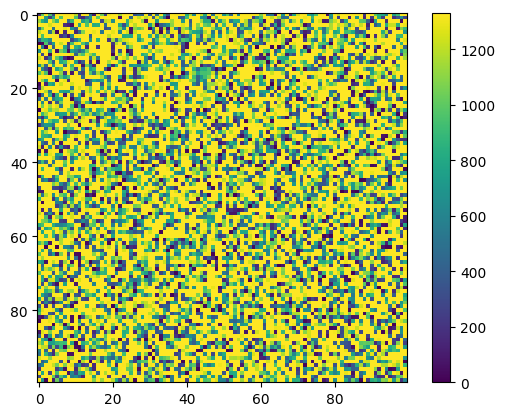

In [43]:
plt.imshow(samples.reshape(100,100))
plt.colorbar()

In [44]:
# im
trace

StaticTrace(
  gen_fn=StaticGenerativeFunction(source=<function model>),
  args=(
    i32[2],
    ModelArgs(
      color_tolerance=f32[],
      depth_tolerance=f32[],
      inlier_score=f32[],
      outlier_prob=f32[],
      color_multiplier=f32[],
      depth_multiplier=f32[]
    ),
  ),
  retval=((f32[128,128,3], f32[128,128,3]), (f32[128,128], f32[128,128])),
  address_choices=Trie(
    inner={
      'object_0':
      DistributionTrace(
        gen_fn=UniformDiscrete(),
        args=(i32[3],),
        value=i32[],
        score=f32[]
      ),
      'object_pose_0':
      DistributionTrace(
        gen_fn=UniformPose(),
        args=(f32[3], f32[3]),
        value=Pose(position=Array([0.19038287, 0.00490895, 0.12479521], dtype=float32), quaternion=Array([ 0.30436146, -0.7992939 , -0.13316694,  0.5007595 ], dtype=float32)),
        score=f32[]
      ),
      'camera_pose':
      DistributionTrace(
        gen_fn=UniformPose(),
        args=(f32[3], f32[3]),
        value=Pose(position

In [45]:
# actual score with gt pose

In [46]:
## plot in rerun visualiser

In [47]:
object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)

_, _, tri, _ = renderer.rasterize_many(    
    compound_pose[:,None,...],
    object_library.vertices,
    object_library.faces,
    jnp.array([[0, len(object_library.faces)]]),)
tri -= 1

In [48]:
## local posterior invariance tests
## triangle tracker with model correction
## amend nishad's geometry writeup
## fix overlay heatmaps

# should be uniform in projected area



In [49]:
def get_normal_orientation_map(tri, frame, object_library, cam_inv_pose):
    # calculate this after points are transformed
    object_vert_view = cam_inv_pose.apply(object_library.vertices)
    direction = jnp.cross(object_vert_view[object_library.faces][:,1,:] - object_vert_view[object_library.faces][:,0,:],
                        object_vert_view[object_library.faces][:,2,:] - object_vert_view[object_library.faces][:,0,:])
    norm = jnp.divide(direction,jnp.linalg.norm(direction,axis=1)[:,None])
    normals = jnp.multiply(norm[tri[frame]], jnp.where(tri[frame]>=0,1,0)[...,None])

    xs = jnp.arange(-cx,cx)/fx
    ys = jnp.arange(-cy,cy)/fy
    #(x,y,z) = (pix_x/fx, pix_y/fy, 1)
    rays = jnp.stack(jnp.meshgrid(xs,ys)+[jnp.ones((width, height))]).transpose((1,2,0))
    rays = rays/jnp.linalg.norm(rays, axis = 2)[...,None]
    dots = jnp.einsum('ijk,ijk->ij', normals, rays)
    return dots, normals

def get_score_correction(tri, frame, object_library, cam_inv_pose, depth, fx, fy):
    dots, normals = get_normal_orientation_map(tri, frame, object_library, cam_inv_pose)
    depth_correction = jnp.power(depth, 2) * 1/fx * 1/fy
    return depth_correction * 1/dots

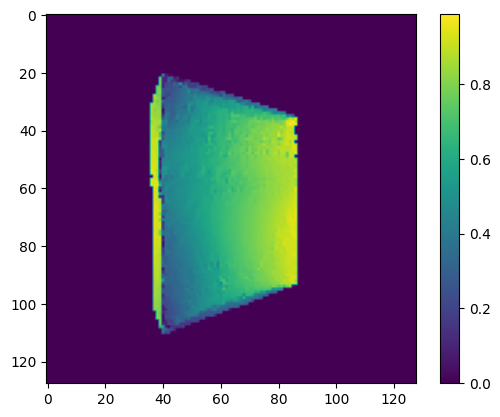

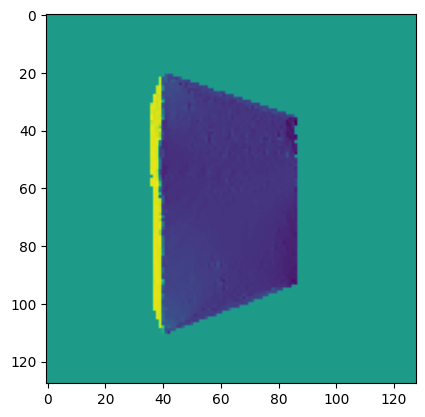

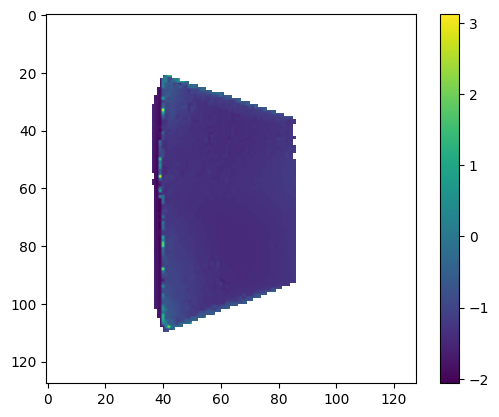

In [50]:
frame = 23
dots, normals = get_normal_orientation_map(tri, frame, object_library, cam_inv_pose)
score_factor = get_score_correction(tri, frame, object_library, cam_inv_pose, depths[frame], fx, fy)

plt.figure()
plt.imshow(jnp.abs(dots))
plt.colorbar()
plt.figure()
plt.imshow(normals[:,:,2])
plt.figure()
plt.imshow(jnp.log(jnp.abs(score_factor)) + 10)
plt.colorbar()


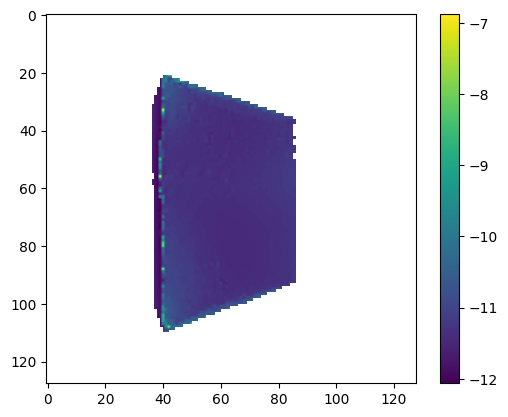

In [51]:
plt.imshow(jnp.log(jnp.nan_to_num(jnp.abs(score_factor))))
plt.colorbar()

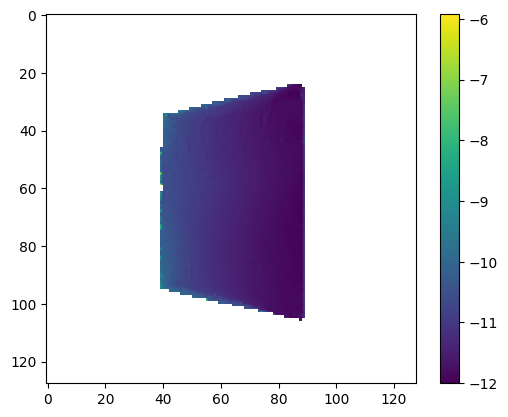

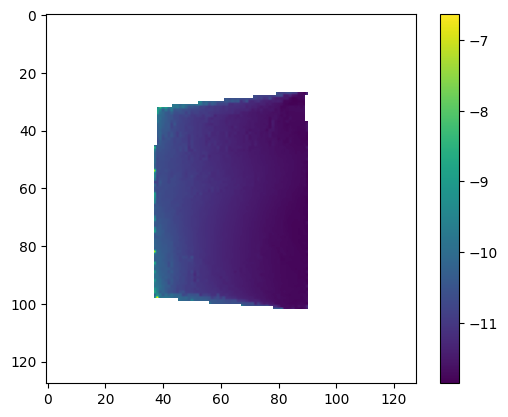

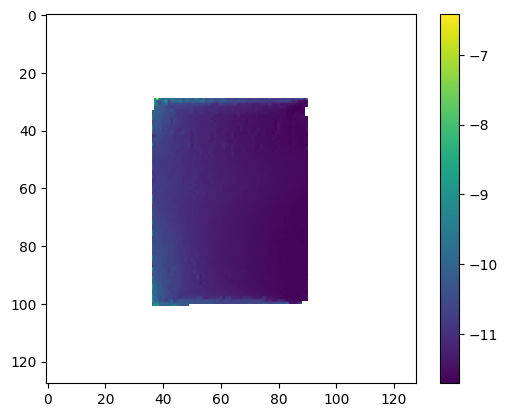

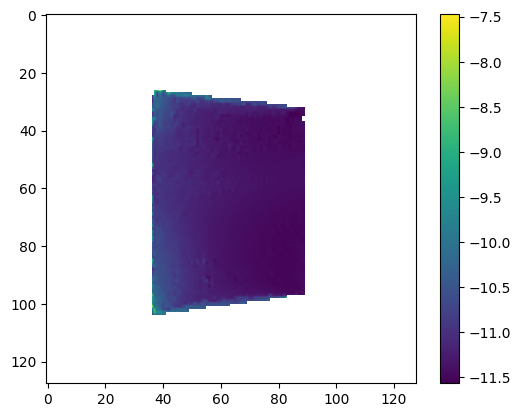

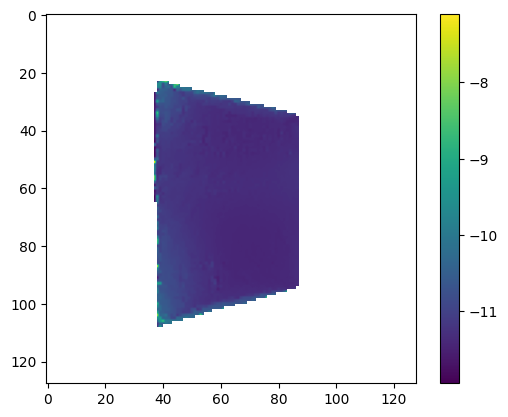

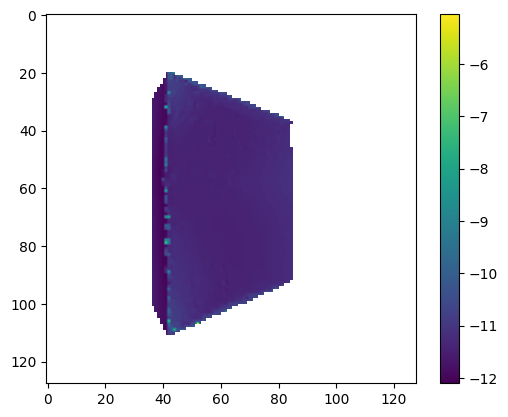

In [52]:
for frame in range(0,len(rgbs),5):
    dots, normals = get_normal_orientation_map(tri, frame, object_library, cam_inv_pose)
    score_factor = get_score_correction(tri, frame, object_library, cam_inv_pose, depths[frame], fx, fy)
    plt.figure()
    plt.imshow(jnp.log(jnp.nan_to_num(jnp.abs(score_factor))))
    plt.colorbar()

In [53]:
jnp.nan_to_num(jnp.abs(score_factor))

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

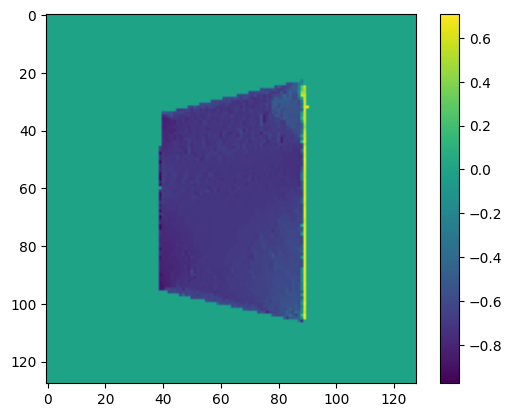

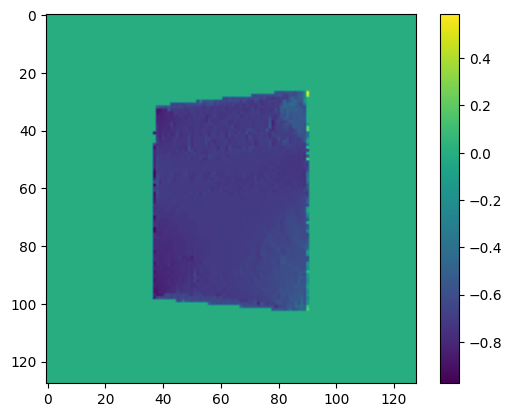

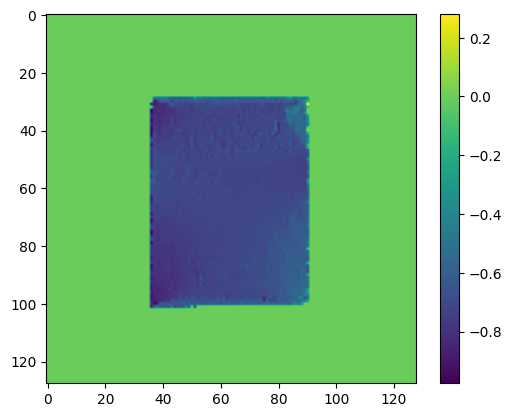

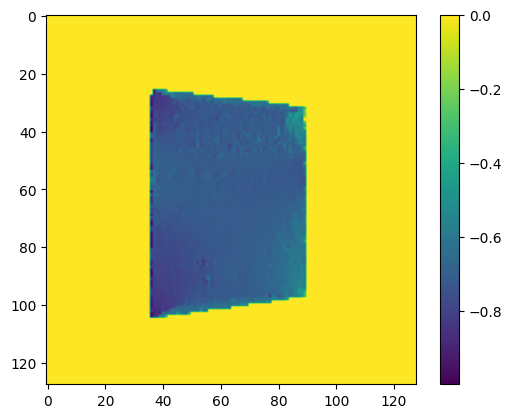

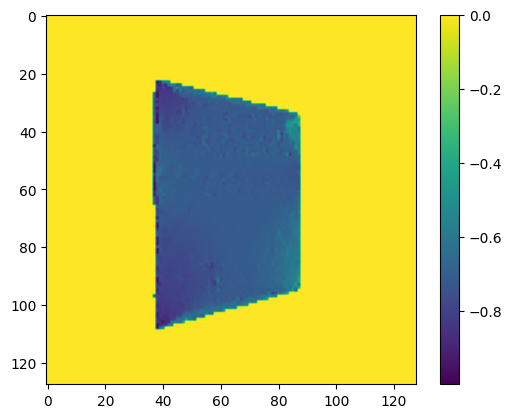

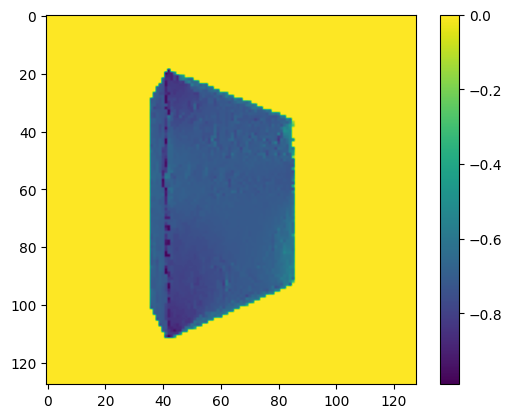

In [54]:
for frame in range(0,len(rgbs),5):
    dots, normals = get_normal_orientation_map(tri, frame, object_library, cam_inv_pose)
    plt.figure()
    plt.imshow(normals[:,:,0])
    plt.colorbar()

In [55]:
# for frame in range(len(rgbs)):
#     rr.set_time_sequence("frame", frame)
#     dots, normals = get_normal_orientation_map(tri, frame, object_library)
#     score_factor = get_score_correction(tri, frame, object_library, depths[frame], fx, fy)
#     im = jnp.nan_to_num(jnp.abs(score_factor))
#     rr.log("/vmf_tracking", rr.Image(observed_rgb))

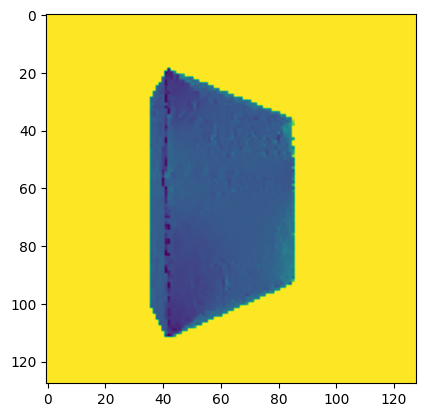

In [56]:
plt.imshow(normals[:,:,0])

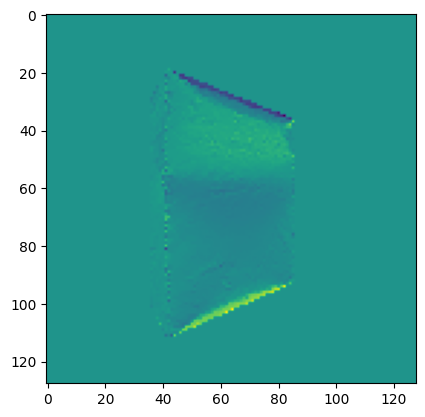

In [57]:
plt.imshow(normals[:,:,1])

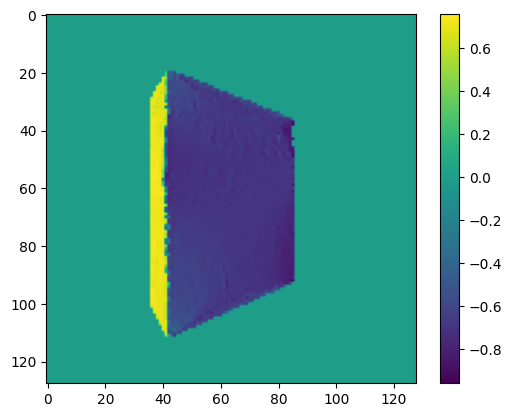

In [58]:
plt.imshow(normals[:,:,2])
plt.colorbar()

In [59]:
cam_inv_pose = b3d.Pose.from_position_and_target(
    jnp.array([0.2, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 0.0])
).inv()


z_shifts = Pose(jnp.linspace(jnp.array([0,0,0]), jnp.array([-2.5,0,0]),30), jnp.array([[0,0,0,1]]*30))


compound_pose = cam_inv_pose @ z_shifts #in_place_rot



rgbs, depths = renderer.render_attribute_many(
    compound_pose[:,None,...],
    object_library.vertices,
    object_library.faces,
    jnp.array([[0, len(object_library.faces)]]),
    object_library.attributes
)

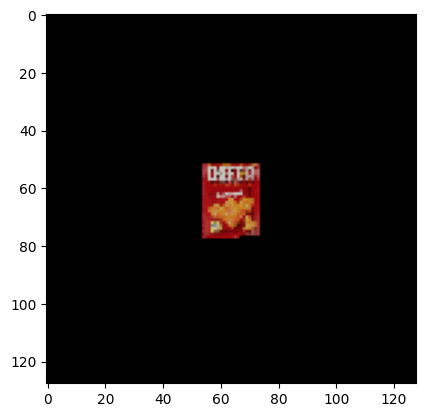

In [60]:
plt.imshow(rgbs[4])

In [61]:
_, _, tri, _ = renderer.rasterize_many(    
    compound_pose[:,None,...],
    object_library.vertices,
    object_library.faces,
    jnp.array([[0, len(object_library.faces)]]),)
tri -= 1

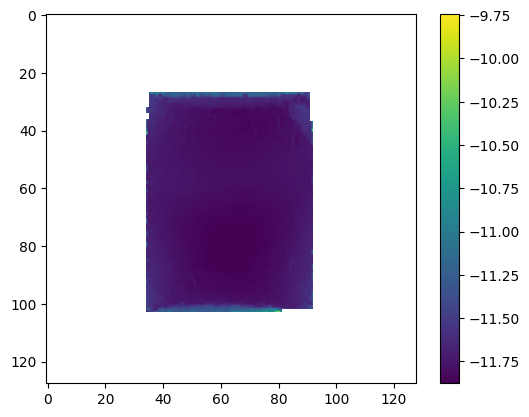

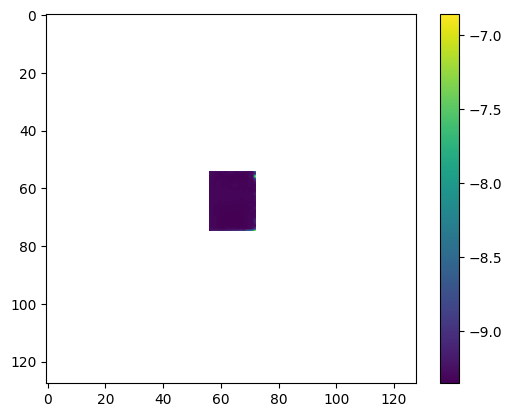

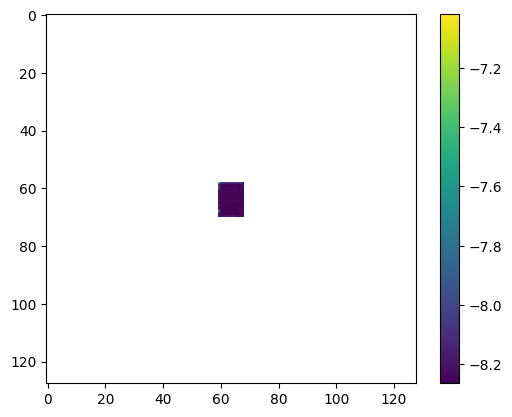

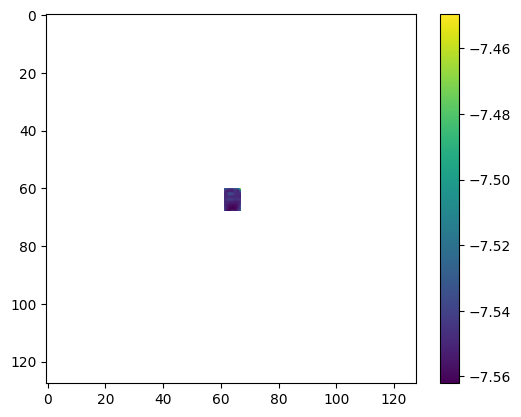

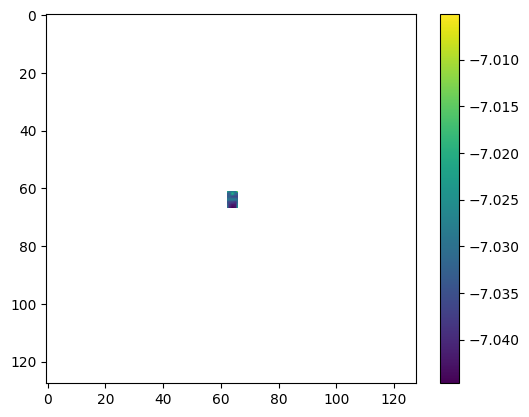

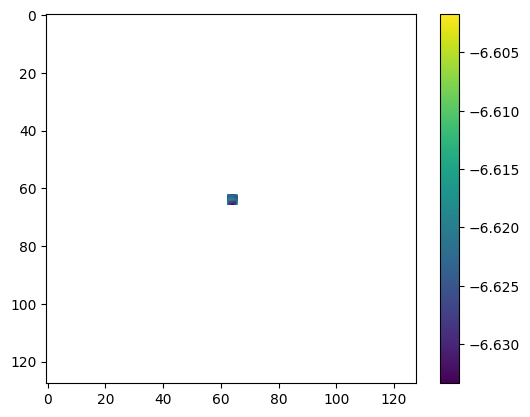

In [62]:
for frame in range(0,len(rgbs),5):
    dots, normals = get_normal_orientation_map(tri, frame, object_library, cam_inv_pose)
    score_factor = get_score_correction(tri, frame, object_library, cam_inv_pose, depths[frame], fx, fy)
    plt.figure()
    plt.imshow(jnp.log(jnp.nan_to_num(jnp.abs(score_factor))))
    plt.colorbar()

In [63]:
# make normals pixel unprojected at 3d, and surface normal vector
# compute the casting of the depth pixel to the camera
# either dot product, or do for four vertices